# Module 4 Project Submission

* Student name: Caitlin Snyder
* Student pace: self-paced
* Scheduled project review date/time: 
* Instructor name: Jeff Herman
* Blog post URL: 


# Introduction

In this post, I'll be training a model to predict pneumonia in chest X-Rays. This will be the first time that I'll be using SageMaker. Let's see how it goes!

# Load the Data

We'll install the necessary libraries and import those that are already locally available.

In [953]:
# !pip3 install tqdm
# !pip3 install s3fs
# !pip3 install seaborn==0.9.0
# !pip3 install imbalanced-learn


In [954]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import os
import io
import shutil
import json
import random
import boto3
import s3fs
import sagemaker
from PIL import Image
from itertools import islice
import requests
from io import BytesIO
from imblearn.pipeline import Pipeline

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from sagemaker.predictor import json_serializer, json_deserializer, Predictor


""" Global variables """
role = sagemaker.get_execution_role()
s3_client = boto3.client('s3')
s3 = boto3.resource('s3')
fs = s3fs.S3FileSystem()

OUTCOMES = ["NORMAL", "PNEUMONIA"]

SESS = sagemaker.Session()
BUCKET = SESS.default_bucket()

PREFIX = "flatiron-module-4"

IMAGE_PREFIX = PREFIX + "/images"
LOAD_PATH = f"s3://{BUCKET}/{IMAGE_PREFIX}/"



### Create annotations

To use SageMaker, we need to store the labels in a specific format. Ultimately, we will store this information in the RecordIO format, which is a '.lst' file. As an intermediary step, however, we will create csv files with each image filepath and its corresponding outcome.

I've already manually loaded the image folders to another s3 bucket.

In [955]:
# https://www.coursera.org/learn/image-classification-sagemaker/ungradedLti/fsCCK/image-classification-with-sagemaker

def convert_dic_to_df(classify_dic):
    df = pd.DataFrame({'image': [], 'value': []})
    for outcome in classify_dic.keys():
        for i, png in enumerate(classify_dic[outcome]):
            image = f"{outcome}/{png.split('/')[-1]}"
            df = df.append({
                'image': image,
                'value': 1 if outcome == "PNEUMONIA" else 0, 
            }, ignore_index=True)
    return df
          
def get_s3_dir_contents(path):
    all_files = s3.Bucket(BUCKET).objects.all()
    return [i.key for i in all_files if i.key.startswith(path)]
    
def get_classifications_as_df(dataset_path):
    classify_dic = {}
    for outcome in OUTCOMES:
        outcome_path = f"{dataset_path}/{outcome}"
        classify_dic[outcome] = get_s3_dir_contents(outcome_path)
    return convert_dic_to_df(classify_dic)
            
def create_annotations_by_type(dataset_type):
    dataset_path = f"{IMAGE_PREFIX}/{dataset_type}"
    df = get_classifications_as_df(dataset_path)
    df.reset_index(inplace=True)
    df.to_csv(f"annotations_{dataset_type}.csv", index=False)
    return df

def create_annotations():
    for i in ["val", "train", "test"]:
        create_annotations_by_type(i)


create_annotations()


### Visualize outcome distribution

We can see in the below that pneumonia outcomes are overrepresented in the train data. To adjust for this imbalance, we will try specifying different weights when we train the model.

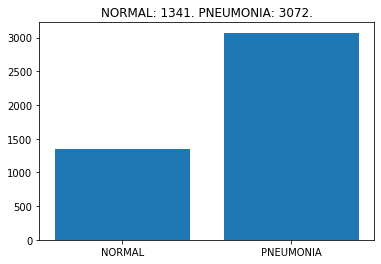

In [957]:
data = pd.read_csv("annotations_train.csv", index_col="index")[["value"]]
cnts = data["value"].value_counts()

pneu = cnts[1.0]
normal = cnts[0.0]

plt.bar(OUTCOMES, [normal, pneu])
title = f"NORMAL: {normal}. PNEUMONIA: {pneu}."
plt.title(title)
plt.show()


### Create .lst files

Now that our annotation files are created, we'll use this data to write the .lst files to our s3 bucket. SageMaker will access the labels on the s3 bucket when fitting the model.

In [958]:
# https://mxnet.apache.org/versions/1.8.0/api/faq/recordio.html
# https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html

def create_lst_file_by_type(dataset_type):
    df = pd.read_csv(f"annotations_{dataset_type}.csv")
    text = ""
    text_col = df.apply(lambda row: f"{int(row['index'])}\t{int(row['value'])}\t{row['image']}\n", axis=1)
    text = "".join(text_col.values.tolist())
    
    s3_client.put_object(Body=text,
                         Bucket=BUCKET, 
                         Key=f"{IMAGE_PREFIX}/{dataset_type}_lst/{dataset_type}.lst")
    
    with open(f"{dataset_type}.lst", "w") as f:
        f.write(text)
    f.close()
   
def create_lst_files():
  for i in ["val", "train", "test"]:
        create_lst_file_by_type(i)

                     
create_lst_files()
                                     

### Visualize a sample of the training data

We can view a sample of our images here in the notebook to make sure that everything is correctly referenced. Using the local annotation csvs, we'll extract the image file paths.


In [959]:
def get_annotations_as_dic(dataset_type):
    dic = {}
    df = pd.read_csv(f"annotations_{dataset_type}.csv")
    for i, row in df.iterrows():
        if not row['image'].endswith(".DS_Store"):
            dic[row['image']] = int(row['value'])
    return dic

def get_annotations_by_type(data_type, dev=False, n=10):
    annotations = get_annotations_as_dic(data_type)
    annotation_keys = list(annotations.keys())
    random.shuffle(annotation_keys)
    if dev:
        downsample = {}
        downsample_keys = annotation_keys[:n]
        for k in downsample_keys:
            downsample[k] = annotations[k]
        return downsample
    else:
        return annotations
    
    
train_annotations = get_annotations_by_type("train")
val_annotations = get_annotations_by_type("val")
test_annotations = get_annotations_by_type("test")


Now let's use those file paths to display a sample of training images.

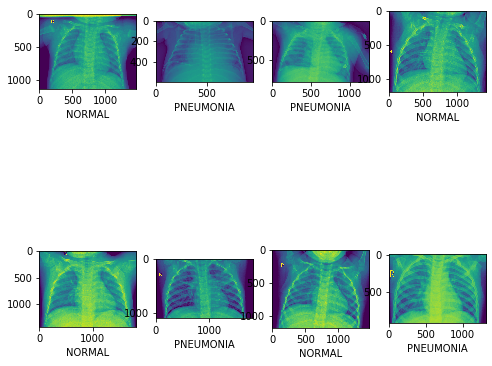

In [961]:
def load_s3_png(path):
    response = s3client.get_object(Bucket=BUCKET, Key=path)
    img_data = response['Body'].read()
    return Image.open(io.BytesIO(img_data))

def viz_data_sample(data_type, annotations):
    plt.figure(figsize=(8,8))
    plt_i = 0
    
    image_paths = list(annotations.keys())
    random.shuffle(image_paths)
    subset = image_paths[:8]
   

    for image in subset:
        outcome = "PNEUMONIA" if annotations[image]==1 else "NORMAL"
        path = f"{IMAGE_PREFIX}/{data_type}/{image}"
        img = load_s3_png(path)
        
        plt.subplot(2, 4, plt_i+1)
        plt.imshow(img)
        plt.xlabel(outcome)
        plt_i += 1
    plt.show()
    

viz_data_sample("train", train_annotations)


# Build and Deploy SageMaker Model

Now we can get started with the SageMaker configuration!

### Define data locations

We'll define the bucket directories where the model should output the report results.

In [962]:
s3_train_path = LOAD_PATH + "train"
s3_train_lst_path = LOAD_PATH + "train_lst"

s3_validation_path = LOAD_PATH + "val"
s3_validation_lst_path = LOAD_PATH + "val_lst"

s3_test_path = LOAD_PATH + "test"
s3_test_lst_path = LOAD_PATH + "test_lst"

output_location = f"s3://{BUCKET}/{PREFIX}/output"
print(f"Training artifacts will be uploaded to: {output_location}")


Training artifacts will be uploaded to: s3://sagemaker-us-east-1-331246566731/flatiron-module-4/output


### Build model

Next, using the SageMaker image-classification container, we'll define our model. 
As hinted at above, I decided to try training the model with weighting on ('use_weighted_loss=1') to address the imbalance in outcome class frequency. Unfortunately, this only succeeded in ensuring that my model predicted every case as normal instead of every case as pneumonia.

In [963]:
training_image = get_image_uri('us-east-1', 'image-classification', repo_version='latest')

model = sagemaker.estimator.Estimator(
    training_image,
    role=role,
    train_instance_count=1,
    train_volume_size=100,
    train_max_run=36000,
    input_mode="File",
    train_instance_type = 'ml.p2.xlarge',
    output_path = output_location,
#     use_weighted_loss=1,
    sagemaker_session = SESS
)


The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Now we set the hyperparameters for our model.

In [967]:
# https://sunjackson.github.io/2018/09/13/84e31f8847e234adb7a5c3eadb253a14/

model.set_hyperparameters(
    num_layers=34,
    image_shape='3,224,224',
    num_classes=2,
    mini_batch_size=16,
    resize=224,
    epochs=100,
    learning_rate=0.01,
    num_training_samples=len(list(train_annotations.keys())),
    augmentation_type='crop_color_transform',
    optimizer="adam",
    use_pretrained_model=1,   
)


### Specify the data locations

First, we need to define the paths that our model will need to use to locate the correct s3 directories.

In [968]:
def get_from_s3(path):
    return sagemaker.session.s3_input(
    path,
    distribution="FullyReplicated",
    content_type="application/x-image",
    s3_data_type="S3Prefix"
)

train_data = get_from_s3(s3_train_path)
train_lst_data = get_from_s3(s3_train_lst_path)

validation_data = get_from_s3(s3_validation_path)
validation_lst_data = get_from_s3(s3_validation_lst_path)

data_channels = {
    'train': train_data,
    'train_lst': train_lst_data,
    'validation': validation_data,
    'validation_lst': validation_lst_data,
}



The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Fit the model

We'll fit the model.

In [ ]:
model.fit(inputs=data_channels, logs=True)


2021-06-22 22:05:52 Starting - Starting the training job...
2021-06-22 22:06:09 Starting - Launching requested ML instancesProfilerReport-1624399551: InProgress
......
2021-06-22 22:07:18 Starting - Preparing the instances for training...............
2021-06-22 22:09:34 Downloading - Downloading input data......
2021-06-22 22:10:41 Training - Downloading the training image..Docker entrypoint called with argument(s): train
[06/22/2021 22:11:08 INFO 139871858378560] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/image_classification/default-input.json: {'use_pretrained_model': 0, 'num_layers': 152, 'epochs': 30, 'learning_rate': 0.1, 'lr_scheduler_factor': 0.1, 'optimizer': 'sgd', 'momentum': 0, 'weight_decay': 0.0001, 'beta_1': 0.9, 'beta_2': 0.999, 'eps': 1e-08, 'gamma': 0.9, 'mini_batch_size': 32, 'image_shape': '3,224,224', 'precision_dtype': 'float32'}
[06/22/2021 22:11:08 INFO 139871858378560] Merging with provided configuration from /opt/ml/input/config

### Deploy the model

And now we get to deploy our model--We'll save the endpoint to reference it and delete the related resources later when we clean up. This will help us avoid AWS charges for lingering, unused resources.

In [ ]:
predictor = model.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")
endpoint_name = predictor.endpoint_name
print("\nEndpoint name: ", endpoint_name)


# Predict Pneumonia Cases

Finally! It's time to find out how accurately our model classifies chest X-rays.

### Get test images

We'll load the test image s3 paths from the annotations file we created earlier.

In [ ]:
# endpoint_name = "image-classification-2021-06-22-01-42-51-569"

predictor = Predictor(endpoint_name=endpoint_name, sagemaker_session=SESS, accept='application/json')

image_names = pd.read_csv("annotations_test.csv")["image"].values.tolist()
image_paths = [f"{IMAGE_PREFIX}/test/{image}" for image in image_names]


Now we'll use our model to classify each image and compare the predicted outcome with the actual outcome.

In [ ]:
# https://github.com/aws/amazon-sagemaker-examples/issues/1885
PREDS = []
ACTUALS = []


def get_prediction_accuracy(deployed, image_path):
    byte_str = s3client.get_object(Bucket=BUCKET, Key=image_path)['Body'].read()
    b = bytearray(byte_str)

    result = deployed.predict(b, initial_args={'ContentType': 'image/jpeg'})
    result = json.loads(result)
    
    prediction = OUTCOMES[np.argmax(result)]
    PREDS.append(prediction)
    
    actual_outcome = image_path.split("/")[-2]
    ACTUALS.append(actual_outcome)
    
    print(actual_outcome, prediction)
    
    return actual_outcome == prediction


### Evaluate model accuracy

In our read-out, we can see that our overall accuracy rate is not overwhelming: 36.38%. In an earlier iteration, the accuracy rate was 62.5% -- but it was automatically classifying everything as "pneumonia." At least now our model can correctly predict *some* normal cases.

In [ ]:
results = [get_prediction_accuracy(predictor, path) for path in image_paths]
accuracy = sum(results) / len(results)
acc_msg = f"Accuracy rate: {round(accuracy * 100, 2)}%"
print(acc_msg)


Our confusion matrix sheds more light on our model's predictive power.


In [ ]:
# https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

conf = confusion_matrix(ACTUALS, PREDS, labels=OUTCOMES)
sns.heatmap(conf/np.sum(conf), annot=True,fmt='.0%', cmap='Blues')


# Disconnect

Before we wrap up, we need to make sure that we delete all of the resources created above. This will ensure that we don't get billed for unused resources.

In [ ]:
# sm = boto3.client('sagemaker')
# sm.delete_endpoint_config(EndpointConfigName=endpoint_name)
# sm.delete_endpoint(EndpointName=endpoint_name)
# sm.delete_model(ModelName=endpoint_name)
